<a href="https://colab.research.google.com/github/RobertFlan02/Dietetics-FYP/blob/main/Experiments/DeepLab/Expierment%203/DeeLabExperiment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

{}

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install bayesian-optimization -q

In [2]:
!kaggle datasets download -d eather00/eduardopachecofoodseg103

Dataset URL: https://www.kaggle.com/datasets/eather00/eduardopachecofoodseg103
License(s): apache-2.0
100% 1.16G/1.16G [00:49<00:00, 26.4MB/s]
100% 1.16G/1.16G [00:50<00:00, 25.0MB/s]


In [3]:
import zipfile
with zipfile.ZipFile('eduardopachecofoodseg103.zip', 'r') as zip_ref:
    zip_ref.extractall('foodseg103')

In [ ]:
# %% [code]
# ==============================
# Imports
# ==============================
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from bayes_opt import BayesianOptimization

# ==============================
# Helper Functions & Classes
# ==============================

def compute_metrics_from_confusion(conf_matrix):
    """Compute pixel accuracy, mean IoU, and mean Dice from a confusion matrix."""
    pixel_acc = np.trace(conf_matrix) / conf_matrix.sum() if conf_matrix.sum() > 0 else 0
    iou_list = []
    dice_list = []
    for i in range(conf_matrix.shape[0]):
        intersection = conf_matrix[i, i]
        union = conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i]
        if union == 0:
            iou = np.nan
            dice = np.nan
        else:
            iou = intersection / union
            dice = 2 * intersection / (conf_matrix[i, :].sum() + conf_matrix[:, i].sum())
        iou_list.append(iou)
        dice_list.append(dice)
    mean_iou = np.nanmean(iou_list)
    mean_dice = np.nanmean(dice_list)
    return pixel_acc, mean_iou, mean_dice

# Applies the same transformation to the image and the mask.
class JointTransform:
    def __init__(self, flip_prob=0.5, rotation_degrees=0):
        self.flip_prob = flip_prob
        self.rotation_degrees = rotation_degrees

    def __call__(self, img, mask):
        # Random horizontal flip.
        if np.random.random() < self.flip_prob:
            img = transforms.functional.hflip(img)
            mask = transforms.functional.hflip(mask)
        # Random rotation with expand=True so that the image is not cropped too much.
        if self.rotation_degrees:
            angle = np.random.uniform(-self.rotation_degrees, self.rotation_degrees)
            img = transforms.functional.rotate(img, angle, interpolation=Image.BILINEAR, expand=True)
            mask = transforms.functional.rotate(mask, angle, interpolation=Image.NEAREST, expand=True)
        return img, mask

# Custom Dataset for Food Segmentation.
class FoodSegDataset(Dataset):
    def __init__(self, dataframe, img_transform=None, mask_resize=None, joint_transform=None):
        self.df = dataframe  # DataFrame with columns 'image' and 'label'
        self.img_transform = img_transform
        self.mask_resize = mask_resize
        self.joint_transform = joint_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Load image.
        image_dict = row['image']
        img = Image.open(io.BytesIO(image_dict.get("bytes"))).convert("RGB")
        # Load mask.
        label_dict = row['label']
        mask = Image.open(io.BytesIO(label_dict.get("bytes")))
        # Apply joint augmentation (only in training).
        if self.joint_transform is not None:
            img, mask = self.joint_transform(img, mask)
        if self.mask_resize:
            mask = self.mask_resize(mask)
        if self.img_transform:
            img = self.img_transform(img)
        mask = torch.from_numpy(np.array(mask)).long()
        return img, mask

# ==============================
# Data Loading
# ==============================
# Load the CSV mapping from Class Id to Class Name.
class_mappings = pd.read_csv('/content/foodseg103/class_mappings.csv')
id_to_food = dict(zip(class_mappings["Class Id"], class_mappings["Class Name"]))

# Create Training Dataset by reading and concatenating parquet files.
train_files = [
    '/content/foodseg103/train-00000-of-00003-6bb37ec387d1825a.parquet',
    '/content/foodseg103/train-00001-of-00003-4a1caa37147c0681.parquet',
    '/content/foodseg103/train-00002-of-00003-c8b698399244cd95.parquet'
]
train_dfs = [pd.read_parquet(f) for f in train_files]
full_train_df = pd.concat(train_dfs, ignore_index=True)
print("Full training data shape:", full_train_df.shape)

# Split into training and testing sets (80/20 split).
train_df, test_df = train_test_split(full_train_df, test_size=0.2, random_state=42)
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

# For economical hyperparameter tuning, use a small subset.
train_df_small = train_df.head(100)  # first 100 samples
test_df_small = test_df.head(50)     # first 50 samples

# ==============================
# Bayesian Optimization Objective Function
# ==============================
def train_evaluate(learning_rate, flip_prob, rotation_degrees, img_scale, weight_decay):
    """
    Trains DeepLabV3 on a small subset for a few epochs with the given hyperparameters,
    then returns the mean IoU (mIoU) from the validation set.

    Hyperparameters:
      - learning_rate: float, learning rate for the optimizer.
      - flip_prob: float [0, 1], probability for horizontal flip augmentation.
      - rotation_degrees: float [0, 30], maximum degrees for random rotation.
      - img_scale: float [0.6, 1.0], scale factor for the image resolution relative to 513x513.
      - weight_decay: float, weight decay for the optimizer.
    """
    # Ensure rotation_degrees is an integer.
    rotation_degrees = int(round(rotation_degrees))
    # Compute effective image size.
    effective_img_size = (int(round(513 * img_scale)), int(round(513 * img_scale)))

    # Local hyperparameters for a quick evaluation.
    local_hparams = {
        "img_size": effective_img_size,
        "batch_size": 4,
        "num_epochs": 3,  # Fewer epochs for quick evaluation.
        "learning_rate": learning_rate,
        "num_workers": 1,
        "num_classes": 104,
        "use_amp": True,
        "flip_prob": flip_prob,
        "rotation_degrees": rotation_degrees,
        "weight_decay": weight_decay,
    }

    # Define image transforms with the effective image size.
    img_transform_local = transforms.Compose([
        transforms.Resize(local_hparams["img_size"]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    mask_resize_local = transforms.Resize(local_hparams["img_size"], interpolation=Image.NEAREST)
    joint_transform_local = JointTransform(
        flip_prob=local_hparams["flip_prob"],
        rotation_degrees=local_hparams["rotation_degrees"]
    )

    # Create local datasets and dataloaders.
    train_dataset_local = FoodSegDataset(train_df_small,
                                         img_transform=img_transform_local,
                                         mask_resize=mask_resize_local,
                                         joint_transform=joint_transform_local)
    train_loader_local = DataLoader(train_dataset_local,
                                    batch_size=local_hparams["batch_size"],
                                    shuffle=True,
                                    num_workers=local_hparams["num_workers"])

    test_dataset_local = FoodSegDataset(test_df_small,
                                        img_transform=img_transform_local,
                                        mask_resize=mask_resize_local,
                                        joint_transform=None)
    test_loader_local = DataLoader(test_dataset_local,
                                   batch_size=local_hparams["batch_size"],
                                   shuffle=False,
                                   num_workers=local_hparams["num_workers"])

    # ------------------------------
    # Build DeepLabV3 Model
    # ------------------------------
    model_local = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
    # Freeze backbone layers.
    for param in model_local.backbone.parameters():
        param.requires_grad = False
    # Replace the classifier's final layer for our number of classes.
    model_local.classifier[4] = nn.Conv2d(256, local_hparams["num_classes"], kernel_size=1)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_local = model_local.to(device)

    # Loss, optimizer, scheduler, and AMP scaler.
    criterion_local = nn.CrossEntropyLoss()
    optimizer_local = optim.Adam(filter(lambda p: p.requires_grad, model_local.parameters()),
                                 lr=local_hparams["learning_rate"],
                                 weight_decay=local_hparams["weight_decay"])
    scheduler_local = ReduceLROnPlateau(optimizer_local, mode='min', factor=0.5, patience=1, verbose=False)
    scaler_local = torch.cuda.amp.GradScaler() if local_hparams["use_amp"] and device.type == 'cuda' else None

    # ------------------------------
    # Training Loop
    # ------------------------------
    model_local.train()
    for epoch in range(local_hparams["num_epochs"]):
        for images, masks in train_loader_local:
            images = images.to(device)
            masks = masks.to(device)

            optimizer_local.zero_grad()
            if scaler_local is not None:
                with torch.cuda.amp.autocast():
                    outputs = model_local(images)['out']
                    loss = criterion_local(outputs, masks)
                scaler_local.scale(loss).backward()
                scaler_local.step(optimizer_local)
                scaler_local.update()
            else:
                outputs = model_local(images)['out']
                loss = criterion_local(outputs, masks)
                loss.backward()
                optimizer_local.step()

    # ------------------------------
    # Evaluation Loop
    # ------------------------------
    model_local.eval()
    test_conf_matrix = np.zeros((local_hparams["num_classes"], local_hparams["num_classes"]), dtype=np.int64)
    with torch.no_grad():
        for images, masks in test_loader_local:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model_local(images)['out']
            preds = outputs.argmax(dim=1).detach().cpu().numpy()
            targets = masks.detach().cpu().numpy()
            preds_flat = preds.flatten()
            targets_flat = targets.flatten()
            batch_conf = np.bincount(
                local_hparams["num_classes"] * targets_flat + preds_flat,
                minlength=local_hparams["num_classes"]**2
            ).reshape(local_hparams["num_classes"], local_hparams["num_classes"])
            test_conf_matrix += batch_conf

    # Compute metrics and return the mean IoU.
    _, test_mean_iou, _ = compute_metrics_from_confusion(test_conf_matrix)
    return test_mean_iou

# ==============================
# Bayesian Optimization Setup
# ==============================
# Define the search space bounds:
# - learning_rate: 1e-5 to 1e-3.
# - flip_prob: 0 (no flip) to 1 (always flip).
# - rotation_degrees: 0 to 30 degrees.
# - img_scale: scale factor from 0.6 (lower resolution) to 1.0 (full resolution).
# - weight_decay: 1e-6 to 1e-3.
pbounds = {
    'learning_rate': (1e-5, 1e-3),
    'flip_prob': (0.0, 1.0),
    'rotation_degrees': (0, 30),
    'img_scale': (0.6, 1.0),
    'weight_decay': (1e-6, 1e-3)
}

optimizer_bo = BayesianOptimization(
    f=train_evaluate,
    pbounds=pbounds,
    random_state=42,
)

print("Starting Bayesian Optimization...")
optimizer_bo.maximize(
    init_points=5,  # Number of random initial points.
    n_iter=10       # Number of optimization iterations.
)

print("Best result found:")
print(optimizer_bo.max)


Full training data shape: (4983, 2)
Training set shape: (3986, 2)
Testing set shape: (997, 2)
Starting Bayesian Optimization...
|   iter    |  target   | flip_prob | img_scale | learni... | rotati... | weight... |
-------------------------------------------------------------------------------------


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 221MB/s]
/usr/local/lib/python3.11/dist-

| 1         | 0.02566   | 0.3745    | 0.9803    | 0.0007347 | 17.96     | 0.0001569 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


| 2         | 0.01735   | 0.156     | 0.6232    | 0.0008675 | 18.03     | 0.0007084 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


| 3         | 0.0217    | 0.02058   | 0.988     | 0.0008341 | 6.37      | 0.0001826 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


| 4         | 0.02088   | 0.1834    | 0.7217    | 0.0005295 | 12.96     | 0.0002919 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


| 5         | 0.02147   | 0.6119    | 0.6558    | 0.0002992 | 10.99     | 0.0004566 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-3b62bc0a2303>:205: FutureWarning: `torch.cuda.amp.GradScaler(args...)`

| 6         | 0.0183    | 0.3871    | 0.8764    | 0.0002655 | 24.96     | 0.0006102 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-3b62bc0a2303>:205: FutureWarning: `torch.cuda.amp.GradScaler(args...)`

| 7         | 0.02108   | 0.9064    | 0.6421    | 0.0001558 | 27.76     | 0.0007709 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-3b62bc0a2303>:205: FutureWarning: `torch.cuda.amp.GradScaler(args...)`

| 8         | 0.01313   | 0.584     | 0.6191    | 4.545e-05 | 3.136     | 0.000234  |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-3b62bc0a2303>:205: FutureWarning: `torch.cuda.amp.GradScaler(args...)`

| 9         | 0.01993   | 0.4686    | 0.9972    | 0.0009226 | 12.95     | 0.0003162 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-3b62bc0a2303>:205: FutureWarning: `torch.cuda.amp.GradScaler(args...)`

| 10        | 0.01989   | 0.8076    | 0.6703    | 0.0003236 | 8.066     | 0.0007262 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-3b62bc0a2303>:205: FutureWarning: `torch.cuda.amp.GradScaler(args...)`

| 11        | 0.02186   | 0.4913    | 0.7023    | 0.0007378 | 17.87     | 0.0007983 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-3b62bc0a2303>:205: FutureWarning: `torch.cuda.amp.GradScaler(args...)`

| 12        | 0.02335   | 0.07546   | 0.9248    | 0.000472  | 9.174     | 0.0002994 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-3b62bc0a2303>:205: FutureWarning: `torch.cuda.amp.GradScaler(args...)`

| 13        | 0.01726   | 0.3961    | 0.9922    | 0.0004784 | 17.96     | 0.0002383 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-3b62bc0a2303>:205: FutureWarning: `torch.cuda.amp.GradScaler(args...)`

| 14        | 0.01998   | 0.7281    | 0.867     | 0.0009946 | 12.2      | 0.0005392 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-3b62bc0a2303>:205: FutureWarning: `torch.cuda.amp.GradScaler(args...)`

| 15        | 0.02377   | 0.1336    | 0.8949    | 0.0003083 | 5.686     | 0.0002276 |
Best result found:
{'target': 0.025655980613734856, 'params': {'flip_prob': 0.3745401188473625, 'img_scale': 0.9802857225639665, 'learning_rate': 0.000734674002393291, 'rotation_degrees': 17.959754525911098, 'weight_decay': 0.0001568626218019941}}


In [ ]:
# %% [code]
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# ------------------------------
# Hyperparameters (from Bayesian Optimization)
# ------------------------------
# Note: The effective image size is computed from the scale factor.
OPT_HYPERPARAMS = {
    "img_scale": 0.9802857225639665,
    "batch_size": 4,
    "num_epochs": 10,
    "learning_rate": 0.000734674002393291,
    "weight_decay": 0.0001568626218019941,
    "num_workers": 1,
    "num_classes": 104,
    "use_amp": True,
    "flip_prob": 0.3745401188473625,
    "rotation_degrees": 17.959754525911098
}
# Compute effective image size based on the scaling factor.
base_size = 513
OPT_HYPERPARAMS["img_size"] = (int(round(base_size * OPT_HYPERPARAMS["img_scale"])),
                                int(round(base_size * OPT_HYPERPARAMS["img_scale"])))

print("Using Hyperparameters:")
for key, value in OPT_HYPERPARAMS.items():
    print(f"  {key}: {value}")

# ------------------------------
# Helper Functions & Classes
# ------------------------------
def compute_metrics_from_confusion(conf_matrix):
    """Compute pixel accuracy, mean IoU, and mean Dice from a confusion matrix."""
    pixel_acc = np.trace(conf_matrix) / conf_matrix.sum() if conf_matrix.sum() > 0 else 0
    iou_list = []
    dice_list = []
    for i in range(conf_matrix.shape[0]):
        intersection = conf_matrix[i, i]
        union = conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i]
        if union == 0:
            iou = np.nan
            dice = np.nan
        else:
            iou = intersection / union
            dice = 2 * intersection / (conf_matrix[i, :].sum() + conf_matrix[:, i].sum())
        iou_list.append(iou)
        dice_list.append(dice)
    mean_iou = np.nanmean(iou_list)
    mean_dice = np.nanmean(dice_list)
    return pixel_acc, mean_iou, mean_dice

# Applies the same transformation to the image and the mask.
class JointTransform:
    def __init__(self, flip_prob=0.5, rotation_degrees=0):
        self.flip_prob = flip_prob
        self.rotation_degrees = rotation_degrees

    def __call__(self, img, mask):
        # Random horizontal flip.
        if np.random.random() < self.flip_prob:
            img = transforms.functional.hflip(img)
            mask = transforms.functional.hflip(mask)
        # Random rotation with expand=True so that the image is not cropped.
        if self.rotation_degrees:
            angle = np.random.uniform(-self.rotation_degrees, self.rotation_degrees)
            img = transforms.functional.rotate(img, angle, interpolation=Image.BILINEAR, expand=True)
            mask = transforms.functional.rotate(mask, angle, interpolation=Image.NEAREST, expand=True)
        return img, mask

# Custom Dataset for Food Segmentation.
class FoodSegDataset(Dataset):
    def __init__(self, dataframe, img_transform=None, mask_resize=None, joint_transform=None):
        self.df = dataframe  # DataFrame with columns 'image' and 'label'
        self.img_transform = img_transform
        self.mask_resize = mask_resize
        self.joint_transform = joint_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Load image.
        image_dict = row['image']
        img = Image.open(io.BytesIO(image_dict.get("bytes"))).convert("RGB")
        # Load mask.
        label_dict = row['label']
        mask = Image.open(io.BytesIO(label_dict.get("bytes")))
        # Apply joint augmentation (only for training).
        if self.joint_transform is not None:
            img, mask = self.joint_transform(img, mask)
        if self.mask_resize:
            mask = self.mask_resize(mask)
        if self.img_transform:
            img = self.img_transform(img)
        mask = torch.from_numpy(np.array(mask)).long()
        return img, mask

# ------------------------------
# Data Loading
# ------------------------------
# Load the CSV mapping from Class Id to Class Name.
class_mappings = pd.read_csv('/content/foodseg103/class_mappings.csv')
id_to_food = dict(zip(class_mappings["Class Id"], class_mappings["Class Name"]))

# Create Training Dataset by reading and concatenating parquet files.
train_files = [
    '/content/foodseg103/train-00000-of-00003-6bb37ec387d1825a.parquet',
    '/content/foodseg103/train-00001-of-00003-4a1caa37147c0681.parquet',
    '/content/foodseg103/train-00002-of-00003-c8b698399244cd95.parquet'
]
train_dfs = [pd.read_parquet(f) for f in train_files]
full_train_df = pd.concat(train_dfs, ignore_index=True)
print("Full training data shape:", full_train_df.shape)

# Split the full training data into a training set and a testing set (80/20 split).
train_df, test_df = train_test_split(full_train_df, test_size=0.2, random_state=42)
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

# ------------------------------
# Define Transforms and Datasets
# ------------------------------
img_transform = transforms.Compose([
    transforms.Resize(OPT_HYPERPARAMS["img_size"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
mask_resize = transforms.Resize(OPT_HYPERPARAMS["img_size"], interpolation=Image.NEAREST)

# Use joint augmentation for training.
joint_transform = JointTransform(
    flip_prob=OPT_HYPERPARAMS["flip_prob"],
    rotation_degrees=OPT_HYPERPARAMS["rotation_degrees"]
)

# Create datasets and dataloaders.
train_dataset = FoodSegDataset(train_df, img_transform=img_transform,
                               mask_resize=mask_resize, joint_transform=joint_transform)
train_loader = DataLoader(train_dataset, batch_size=OPT_HYPERPARAMS["batch_size"],
                          shuffle=True, num_workers=OPT_HYPERPARAMS["num_workers"])

test_dataset = FoodSegDataset(test_df, img_transform=img_transform,
                              mask_resize=mask_resize, joint_transform=None)
test_loader = DataLoader(test_dataset, batch_size=OPT_HYPERPARAMS["batch_size"],
                         shuffle=False, num_workers=OPT_HYPERPARAMS["num_workers"])

# ------------------------------
# Build Model
# ------------------------------
# Load pretrained DeepLabV3 with ResNet-50 backbone from PyTorch Hub.
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
# Freeze the backbone so that only the classifier is trained.
for param in model.backbone.parameters():
    param.requires_grad = False
# Replace the classifier’s final conv layer.
model.classifier[4] = nn.Conv2d(256, OPT_HYPERPARAMS["num_classes"], kernel_size=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ------------------------------
# Loss, Optimizer, Scheduler, and AMP Scaler
# ------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=OPT_HYPERPARAMS["learning_rate"],
                       weight_decay=OPT_HYPERPARAMS["weight_decay"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)
scaler = torch.cuda.amp.GradScaler() if OPT_HYPERPARAMS["use_amp"] and device.type == 'cuda' else None

# ------------------------------
# Training and Validation Loop with Checkpointing
# ------------------------------
train_losses = []
val_losses = []
best_val_loss = float('inf')
model_save_path = "/content/foodseg103/best_deeplabv3_resnet50_foodseg103.pth"

for epoch in range(OPT_HYPERPARAMS["num_epochs"]):
    model.train()
    train_loss = 0.0
    # Initialize confusion matrix for training.
    train_conf_matrix = np.zeros((OPT_HYPERPARAMS["num_classes"], OPT_HYPERPARAMS["num_classes"]), dtype=np.int64)

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{OPT_HYPERPARAMS['num_epochs']} [Training]")
    for images, masks in train_bar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(images)['out']
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

        train_loss += loss.item()

        # Update confusion matrix.
        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        targets = masks.detach().cpu().numpy()
        preds_flat = preds.flatten()
        targets_flat = targets.flatten()
        batch_conf = np.bincount(
            OPT_HYPERPARAMS["num_classes"] * targets_flat + preds_flat,
            minlength=OPT_HYPERPARAMS["num_classes"]**2
        ).reshape(OPT_HYPERPARAMS["num_classes"], OPT_HYPERPARAMS["num_classes"])
        train_conf_matrix += batch_conf

        train_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_pixel_acc, train_mean_iou, train_mean_dice = compute_metrics_from_confusion(train_conf_matrix)
    print(f"Epoch [{epoch+1}/{OPT_HYPERPARAMS['num_epochs']}], "
          f"Train Loss: {avg_train_loss:.4f}, Pixel Acc: {train_pixel_acc:.4f}, "
          f"mIoU: {train_mean_iou:.4f}, mDice: {train_mean_dice:.4f}")

    # ------------------------------
    # Validation
    # ------------------------------
    model.eval()
    test_loss = 0.0
    test_conf_matrix = np.zeros((OPT_HYPERPARAMS["num_classes"], OPT_HYPERPARAMS["num_classes"]), dtype=np.int64)
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{OPT_HYPERPARAMS['num_epochs']} [Testing]")
        for images, masks in test_bar:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            test_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu().numpy()
            targets = masks.detach().cpu().numpy()
            preds_flat = preds.flatten()
            targets_flat = targets.flatten()
            batch_conf = np.bincount(
                OPT_HYPERPARAMS["num_classes"] * targets_flat + preds_flat,
                minlength=OPT_HYPERPARAMS["num_classes"]**2
            ).reshape(OPT_HYPERPARAMS["num_classes"], OPT_HYPERPARAMS["num_classes"])
            test_conf_matrix += batch_conf

            test_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_test_loss = test_loss / len(test_loader)
    val_losses.append(avg_test_loss)
    test_pixel_acc, test_mean_iou, test_mean_dice = compute_metrics_from_confusion(test_conf_matrix)
    print(f"Epoch [{epoch+1}/{OPT_HYPERPARAMS['num_epochs']}], "
          f"Test Loss: {avg_test_loss:.4f}, Pixel Acc: {test_pixel_acc:.4f}, "
          f"mIoU: {test_mean_iou:.4f}, mDice: {test_mean_dice:.4f}")

    scheduler.step(avg_test_loss)

    # Save checkpoint if validation loss improved.
    if avg_test_loss < best_val_loss:
        best_val_loss = avg_test_loss
        torch.save(model.state_dict(), model_save_path)
        print(f"New best model found and saved with Test Loss: {avg_test_loss:.4f}")

# ------------------------------
# Plot Loss Curves
# ------------------------------
plt.figure(figsize=(8, 6))
plt.plot(range(1, OPT_HYPERPARAMS["num_epochs"]+1), train_losses, label="Training Loss")
plt.plot(range(1, OPT_HYPERPARAMS["num_epochs"]+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()


Using Hyperparameters:
  img_scale: 0.9802857225639665
  batch_size: 4
  num_epochs: 10
  learning_rate: 0.000734674002393291
  weight_decay: 0.0001568626218019941
  num_workers: 1
  num_classes: 104
  use_amp: True
  flip_prob: 0.3745401188473625
  rotation_degrees: 17.959754525911098
  img_size: (503, 503)
Full training data shape: (4983, 2)
Training set shape: (3986, 2)
Testing set shape: (997, 2)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-6-f28a9d667ddd>:185: FutureWarning: `torch.cuda.amp.GradScaler(args...)`

Epoch [1/10], Train Loss: 1.5210, Pixel Acc: 0.6482, mIoU: 0.0302, mDice: 0.0478


Epoch 1/10 [Testing]: 100%|██████████| 250/250 [01:47<00:00,  2.32it/s, loss=1.7168]


Epoch [1/10], Test Loss: 1.5985, Pixel Acc: 0.5979, mIoU: 0.0566, mDice: 0.0876
New best model found and saved with Test Loss: 1.5985


Epoch 2/10 [Training]: 100%|██████████| 997/997 [05:34<00:00,  2.98it/s, loss=1.2570]


Epoch [2/10], Train Loss: 1.2934, Pixel Acc: 0.6769, mIoU: 0.0548, mDice: 0.0864


Epoch 2/10 [Testing]: 100%|██████████| 250/250 [01:47<00:00,  2.32it/s, loss=1.7757]


Epoch [2/10], Test Loss: 1.5404, Pixel Acc: 0.6085, mIoU: 0.0703, mDice: 0.1091
New best model found and saved with Test Loss: 1.5404


Epoch 3/10 [Training]: 100%|██████████| 997/997 [05:36<00:00,  2.96it/s, loss=1.7730]


Epoch [3/10], Train Loss: 1.2241, Pixel Acc: 0.6881, mIoU: 0.0698, mDice: 0.1099


Epoch 3/10 [Testing]: 100%|██████████| 250/250 [01:47<00:00,  2.32it/s, loss=1.8978]


Epoch [3/10], Test Loss: 1.4608, Pixel Acc: 0.6239, mIoU: 0.0885, mDice: 0.1356
New best model found and saved with Test Loss: 1.4608


Epoch 4/10 [Training]: 100%|██████████| 997/997 [05:33<00:00,  2.99it/s, loss=0.7808]


Epoch [4/10], Train Loss: 1.1886, Pixel Acc: 0.6939, mIoU: 0.0770, mDice: 0.1207


Epoch 4/10 [Testing]: 100%|██████████| 250/250 [01:47<00:00,  2.32it/s, loss=1.8333]


Epoch [4/10], Test Loss: 1.4430, Pixel Acc: 0.6240, mIoU: 0.0970, mDice: 0.1498
New best model found and saved with Test Loss: 1.4430


Epoch 5/10 [Training]: 100%|██████████| 997/997 [05:33<00:00,  2.99it/s, loss=1.6071]


Epoch [5/10], Train Loss: 1.1601, Pixel Acc: 0.7009, mIoU: 0.0852, mDice: 0.1332


Epoch 5/10 [Testing]: 100%|██████████| 250/250 [01:47<00:00,  2.32it/s, loss=1.8086]


Epoch [5/10], Test Loss: 1.4273, Pixel Acc: 0.6350, mIoU: 0.0996, mDice: 0.1526
New best model found and saved with Test Loss: 1.4273


Epoch 6/10 [Training]: 100%|██████████| 997/997 [05:36<00:00,  2.96it/s, loss=1.8160]


Epoch [6/10], Train Loss: 1.1423, Pixel Acc: 0.7027, mIoU: 0.0884, mDice: 0.1386


Epoch 6/10 [Testing]: 100%|██████████| 250/250 [01:47<00:00,  2.33it/s, loss=1.9985]


Epoch [6/10], Test Loss: 1.3869, Pixel Acc: 0.6407, mIoU: 0.1033, mDice: 0.1581
New best model found and saved with Test Loss: 1.3869


Epoch 7/10 [Training]: 100%|██████████| 997/997 [05:32<00:00,  3.00it/s, loss=1.3837]


Epoch [7/10], Train Loss: 1.1262, Pixel Acc: 0.7064, mIoU: 0.0927, mDice: 0.1445


Epoch 7/10 [Testing]: 100%|██████████| 250/250 [01:46<00:00,  2.34it/s, loss=1.8988]


Epoch [7/10], Test Loss: 1.3758, Pixel Acc: 0.6413, mIoU: 0.1065, mDice: 0.1631
New best model found and saved with Test Loss: 1.3758


Epoch 8/10 [Training]: 100%|██████████| 997/997 [05:31<00:00,  3.01it/s, loss=1.0264]


Epoch [8/10], Train Loss: 1.1104, Pixel Acc: 0.7089, mIoU: 0.0968, mDice: 0.1502


Epoch 8/10 [Testing]: 100%|██████████| 250/250 [01:46<00:00,  2.34it/s, loss=2.2642]


Epoch [8/10], Test Loss: 1.3977, Pixel Acc: 0.6336, mIoU: 0.1138, mDice: 0.1747


Epoch 9/10 [Training]: 100%|██████████| 997/997 [05:34<00:00,  2.98it/s, loss=0.8597]


Epoch [9/10], Train Loss: 1.1137, Pixel Acc: 0.7078, mIoU: 0.0984, mDice: 0.1538


Epoch 9/10 [Testing]: 100%|██████████| 250/250 [01:46<00:00,  2.35it/s, loss=1.4545]


Epoch [9/10], Test Loss: 1.3865, Pixel Acc: 0.6397, mIoU: 0.1137, mDice: 0.1738


Epoch 10/10 [Training]: 100%|██████████| 997/997 [05:32<00:00,  3.00it/s, loss=1.2397]


Epoch [10/10], Train Loss: 1.0401, Pixel Acc: 0.7233, mIoU: 0.1158, mDice: 0.1782


Epoch 10/10 [Testing]: 100%|██████████| 250/250 [01:46<00:00,  2.35it/s, loss=1.2336]


Epoch [10/10], Test Loss: 1.3202, Pixel Acc: 0.6517, mIoU: 0.1237, mDice: 0.1877
New best model found and saved with Test Loss: 1.3202


In [ ]:
from google.colab import files
files.download("/content/foodseg103/best_deeplabv3_resnet50_foodseg103.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 163MB/s]
<ipython-input-4-947693eacbd9>:


Processing sample 1/10


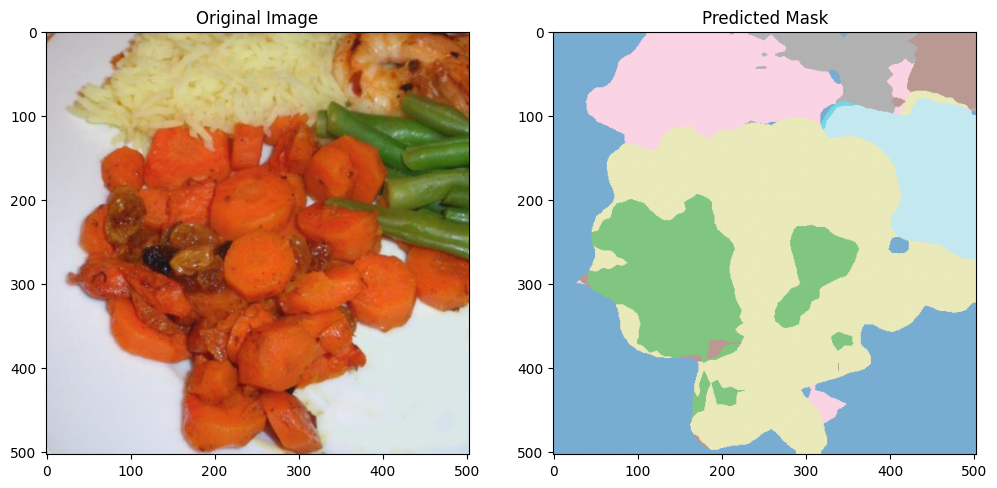

True food items:       ['French beans', 'rice', 'dried cranberries', 'carrot', 'shrimp']
Predicted food items:  ['noodles', 'pasta', 'rice', 'French beans', 'potato', 'chicken duck', 'carrot', 'soy', 'broccoli', 'green beans']
Food Accuracy:        25.00%
Pixel Accuracy:       75.32%
Mean IoU:             24.97%
Mean Dice:            3.44%
Avg. Hausdorff Dist.: 175.74 pixels

Processing sample 2/10


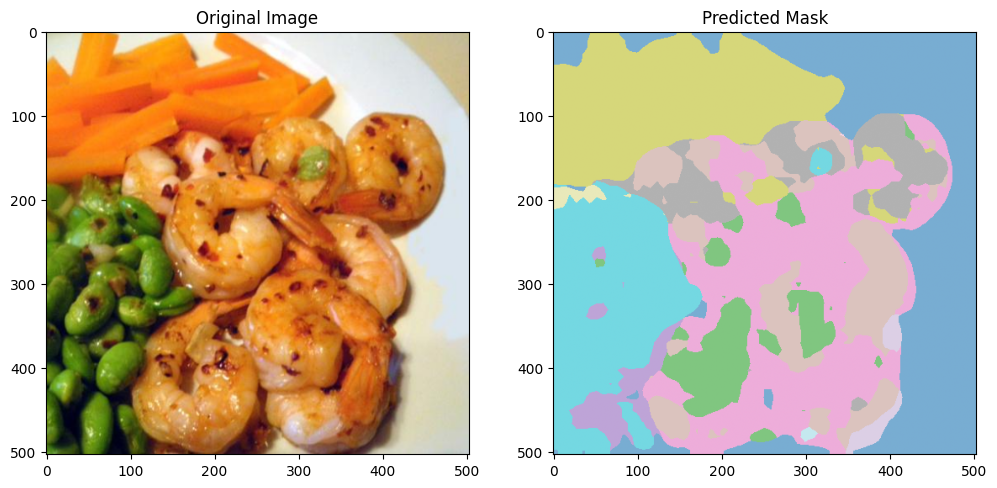

True food items:       ['shrimp', 'carrot', 'green beans']
Predicted food items:  ['pasta', 'noodles', 'potato', 'tomato', 'cucumber', 'carrot', 'soy', 'broccoli', 'cilantro mint', 'pepper', 'green beans', 'white button mushroom', 'grape', 'chicken duck', 'shrimp', 'corn']
Food Accuracy:        18.75%
Pixel Accuracy:       59.52%
Mean IoU:             16.42%
Mean Dice:            3.00%
Avg. Hausdorff Dist.: 80.22 pixels

Processing sample 3/10


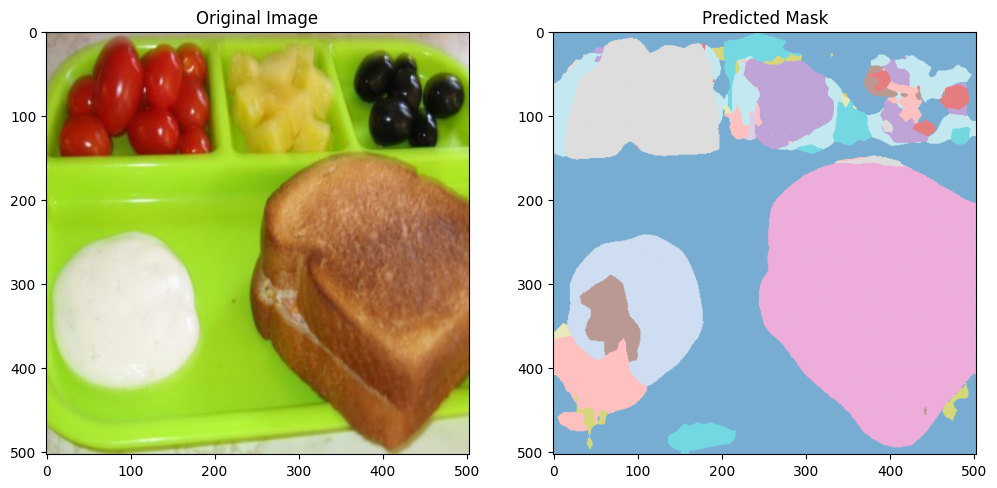

True food items:       ['olives', 'pineapple', 'tomato', 'sauce', 'bread']
Predicted food items:  ['ice cream', 'tomato', 'lettuce', 'cucumber', 'carrot', 'egg', 'celery stick', 'strawberry', 'pepper', 'blueberry', 'green beans', 'mango', 'olives', 'lemon', 'pineapple', 'grape', 'orange', 'sauce', 'bread']
Food Accuracy:        26.32%
Pixel Accuracy:       76.27%
Mean IoU:             17.17%
Mean Dice:            3.81%
Avg. Hausdorff Dist.: 136.68 pixels

Processing sample 4/10


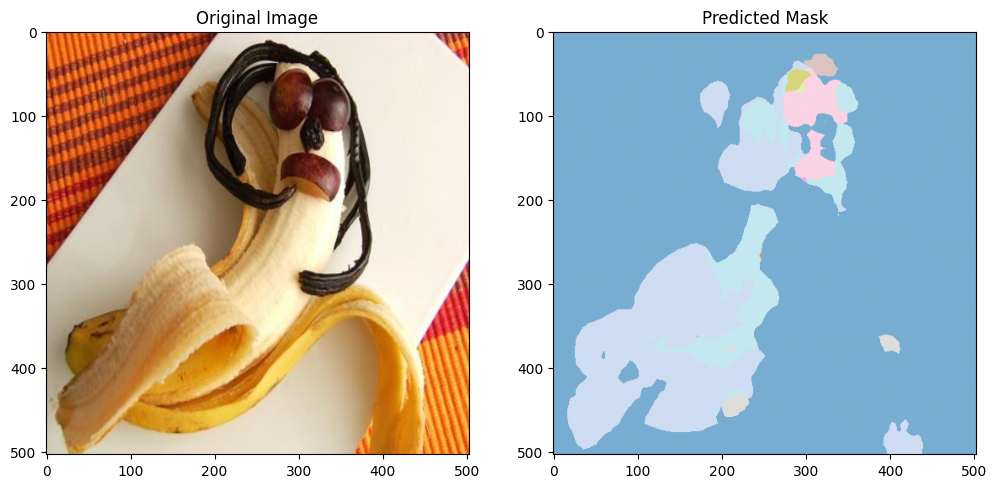

True food items:       ['grape', 'chocolate', 'banana']
Predicted food items:  ['blueberry', 'french fries', 'chocolate', 'biscuit', 'peach', 'fig', 'orange', 'sausage', 'sauce', 'bread', 'banana']
Food Accuracy:        16.67%
Pixel Accuracy:       58.06%
Mean IoU:             5.78%
Mean Dice:            0.83%
Avg. Hausdorff Dist.: 287.73 pixels

Processing sample 5/10


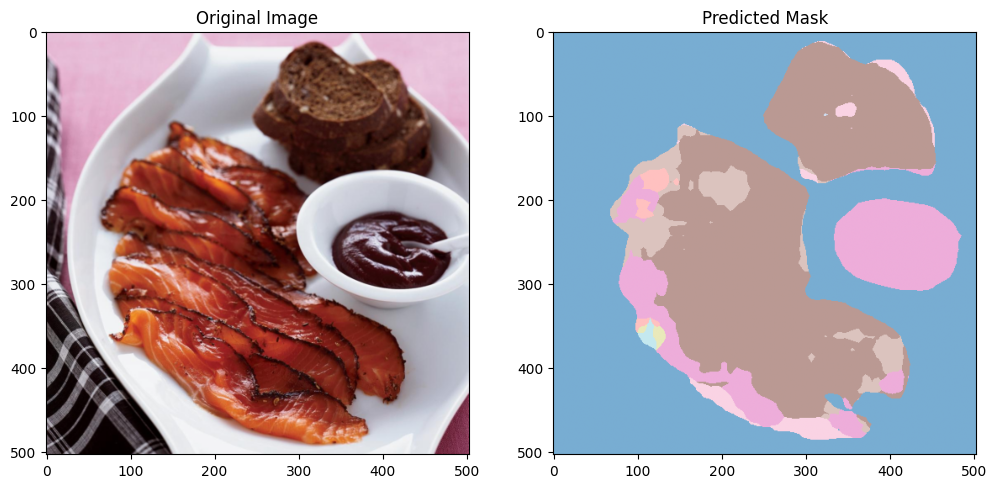

True food items:       ['bread', 'sauce', 'fish']
Predicted food items:  ['biscuit', 'tomato', 'steak', 'chicken duck', 'sausage', 'sauce', 'carrot', 'bread', 'strawberry']
Food Accuracy:        20.00%
Pixel Accuracy:       56.64%
Mean IoU:             12.56%
Mean Dice:            1.56%
Avg. Hausdorff Dist.: 286.67 pixels

Processing sample 6/10


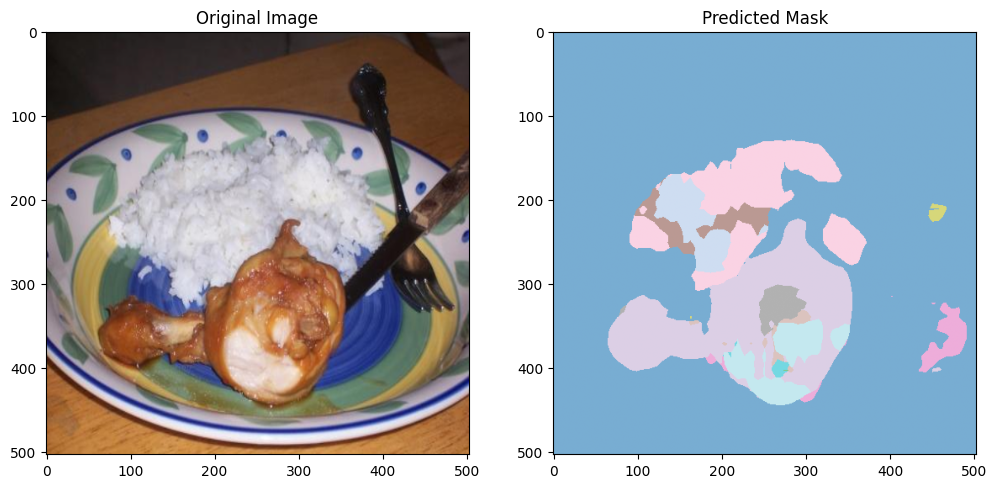

True food items:       ['chicken duck', 'rice']
Predicted food items:  ['noodles', 'rice', 'french fries', 'potato', 'ice cream', 'tomato', 'carrot', 'asparagus', 'egg', 'onion', 'white button mushroom', 'steak', 'chicken duck', 'sauce', 'shrimp']
Food Accuracy:        13.33%
Pixel Accuracy:       81.01%
Mean IoU:             10.61%
Mean Dice:            1.92%
Avg. Hausdorff Dist.: 96.50 pixels

Processing sample 7/10


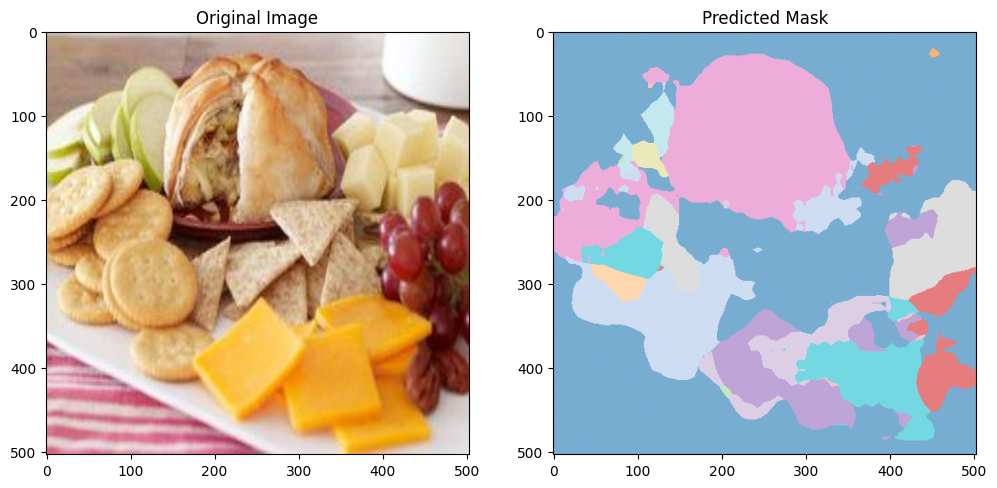

True food items:       ['biscuit', 'other ingredients', 'cheese butter', 'grape', 'apple', 'bread']
Predicted food items:  ['french fries', 'biscuit', 'potato', 'ice cream', 'tomato', 'wine', 'lettuce', 'almond', 'cucumber', 'carrot', 'egg', 'apple', 'banana', 'strawberry', 'onion', 'mango', 'lemon', 'pineapple', 'grape', 'orange', 'steak', 'sausage', 'shrimp', 'bread']
Food Accuracy:        15.38%
Pixel Accuracy:       50.33%
Mean IoU:             6.60%
Mean Dice:            2.18%
Avg. Hausdorff Dist.: 138.69 pixels

Processing sample 8/10


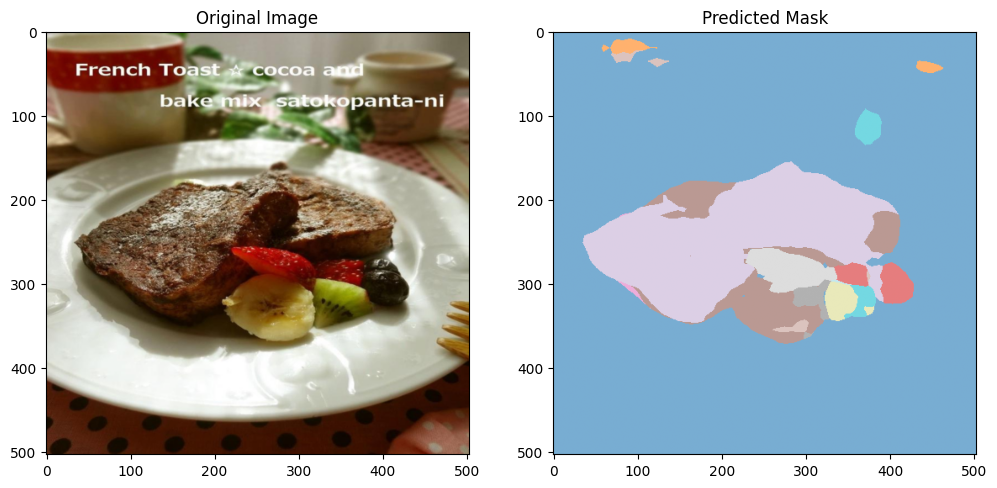

True food items:       ['blueberry', 'kiwi', 'bread', 'banana', 'strawberry']
Predicted food items:  ['potato', 'tomato', 'coffee', 'lettuce', 'cucumber', 'broccoli', 'cilantro mint', 'pepper', 'strawberry', 'blueberry', 'steak', 'chicken duck', 'sauce', 'shrimp', 'bread']
Food Accuracy:        17.65%
Pixel Accuracy:       77.66%
Mean IoU:             9.91%
Mean Dice:            1.99%
Avg. Hausdorff Dist.: 151.15 pixels

Processing sample 9/10


True food items:       ['chicken duck', 'carrot']
Predicted food items:  ['french fries', 'potato', 'pineapple', 'tomato', 'orange', 'steak', 'chicken duck', 'pumpkin', 'carrot', 'bread', 'corn', 'banana']
Food Accuracy:        16.67%
Pixel Accuracy:       61.09%
Mean IoU:             11.85%
Mean Dice:            1.84%
Avg. Hausdorff Dist.: 232.51 pixels

Processing sample 10/10


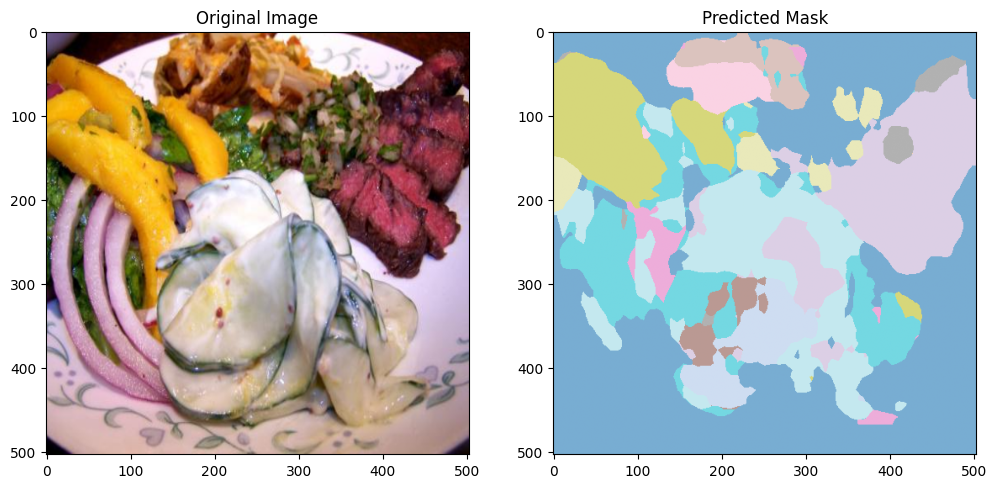

True food items:       ['shiitake', 'other ingredients', 'steak', 'cucumber', 'cilantro mint', 'onion']
Predicted food items:  ['noodles', 'potato', 'ice cream', 'tomato', 'red beans', 'cucumber', 'carrot', 'asparagus', 'broccoli', 'cilantro mint', 'onion', 'pepper', 'French beans', 'shiitake', 'white button mushroom', 'steak', 'chicken duck', 'sauce', 'shrimp']
Food Accuracy:        25.00%
Pixel Accuracy:       37.44%
Mean IoU:             7.23%
Mean Dice:            1.96%
Avg. Hausdorff Dist.: 278.77 pixels

Overall Performance Metrics:
Avg. Pixel Accuracy: 63.33%
Avg. Mean IoU:       12.31%
Avg. Mean Dice:      2.25%
Avg. Hausdorff Dist.: 186.47 pixels


In [4]:
# Evaluation Code
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from matplotlib.colors import ListedColormap
import torch.nn as nn
from pyarrow.parquet import ParquetFile
from scipy.spatial.distance import directed_hausdorff

# -------------------------------------------------------
# Updated Hyperparameters (using the training scale factor)
# -------------------------------------------------------
BASE_SIZE = 513
IMG_SCALE = 0.9802857225639665
IMG_SIZE = (int(round(BASE_SIZE * IMG_SCALE)), int(round(BASE_SIZE * IMG_SCALE)))
HYPERPARAMS = {
    "img_size": IMG_SIZE,    # effective image size computed as in training
    "num_classes": 104,      # Number of segmentation classes
}

# Load class mappings CSV.
class_mappings = pd.read_csv('/content/foodseg103/class_mappings.csv')
id_to_food = dict(zip(class_mappings["Class Id"], class_mappings["Class Name"]))

def load_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Load DeepLabV3 with ResNet-50 backbone; use pretrained weights to match training.
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
    # Replace the final classifier layer.
    model.classifier[4] = nn.Conv2d(256, HYPERPARAMS["num_classes"], kernel_size=1)
    # Load the best model saved from training.
    state_dict = torch.load("/content/foodseg103/best_deeplabv3_resnet50_foodseg103.pth", map_location=device)
    model.load_state_dict(state_dict, strict=False)
    model.to(device)
    model.eval()
    return model, device

# Define the image transform using the updated image size.
img_transform = transforms.Compose([
    transforms.Resize(HYPERPARAMS["img_size"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

def compute_segmentation_metrics(pred, target, num_classes):
    pred, target = pred.flatten(), target.flatten()
    pixel_acc = np.mean(pred == target)
    iou_list, dice_list = [], []
    for cls in range(num_classes):
        pred_inds, target_inds = (pred == cls), (target == cls)
        intersection, union = np.sum(pred_inds & target_inds), np.sum(pred_inds | target_inds)
        iou = np.nan if union == 0 else intersection / union
        dice = (2 * intersection) / (np.sum(pred_inds) + np.sum(target_inds) + 1e-8)
        iou_list.append(iou)
        dice_list.append(dice)
    return pixel_acc, np.nanmean(iou_list), np.nanmean(dice_list)

def hausdorff_distance_for_class(pred, target, cls):
    pred_points, target_points = np.argwhere(pred == cls), np.argwhere(target == cls)
    if pred_points.size == 0 or target_points.size == 0:
        return np.nan
    return max(directed_hausdorff(pred_points, target_points)[0],
               directed_hausdorff(target_points, pred_points)[0])

def compute_average_hausdorff(pred, target, num_classes):
    hd_list = [hausdorff_distance_for_class(pred, target, cls) for cls in range(1, num_classes)]
    valid_hd = [hd for hd in hd_list if not np.isnan(hd)]
    return np.nanmean(valid_hd) if valid_hd else np.nan

def stream_validation_data():
    return ParquetFile("/content/foodseg103/validation-00000-of-00001-a5bfdaa5beb7006a.parquet").iter_batches(batch_size=1)

def process_image(batch, model, device, id_to_food):
    # Load and process the input image and ground-truth mask.
    img = Image.open(io.BytesIO(batch['image'][0].as_py()['bytes'])).convert("RGB")
    gt_mask = np.array(Image.open(io.BytesIO(batch['label'][0].as_py()['bytes'])).resize(HYPERPARAMS["img_size"], Image.NEAREST))

    true_ids = set(np.unique(gt_mask)) - {0}
    true_foods = [id_to_food.get(fid, "Unknown") for fid in true_ids if fid in id_to_food]

    # Transform the image.
    input_tensor = img_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_mask = model(input_tensor)['out'][0].argmax(0).cpu().numpy()

    pred_ids = set(np.unique(pred_mask)) - {0}

    # --- Updated Food Accuracy Calculation ---
    # If there are no true food items, then we assign 100% if no predictions are made.
    if not true_ids:
        food_accuracy = 100.0 if not pred_ids else 0.0
    else:
        union_ids = true_ids | pred_ids
        intersection_ids = true_ids & pred_ids
        food_accuracy = (len(intersection_ids) / len(union_ids)) * 100.0

    pixel_acc, mean_iou, mean_dice = compute_segmentation_metrics(pred_mask, gt_mask, HYPERPARAMS["num_classes"])
    avg_hausdorff = compute_average_hausdorff(pred_mask, gt_mask, HYPERPARAMS["num_classes"])

    predicted_foods = [id_to_food.get(pid, "Unknown") for pid in pred_ids if pid in id_to_food]
    return img, input_tensor, pred_mask, gt_mask, true_foods, predicted_foods, food_accuracy, pixel_acc, mean_iou, mean_dice, avg_hausdorff

def main():
    model, device = load_model()
    val_stream = stream_validation_data()
    cmap = ListedColormap(plt.cm.tab20.colors[:HYPERPARAMS["num_classes"]])
    overall_metrics = {"pixel_acc": [], "mean_iou": [], "mean_dice": [], "hausdorff": []}

    for i, batch in enumerate(val_stream):
        if i >= 10:
            break
        print(f"\nProcessing sample {i+1}/10")
        img, img_tensor, pred_mask, gt_mask, true_foods, predicted_foods, food_acc, pix_acc, mean_iou, mean_dice, hausdorff = process_image(batch, model, device, id_to_food)
        overall_metrics["pixel_acc"].append(pix_acc)
        overall_metrics["mean_iou"].append(mean_iou)
        overall_metrics["mean_dice"].append(mean_dice)
        overall_metrics["hausdorff"].append(hausdorff)

        # Denormalize the image for display.
        img_denorm = img_tensor.squeeze(0) * torch.tensor([0.229, 0.224, 0.225], device=device).view(3, 1, 1) \
                     + torch.tensor([0.485, 0.456, 0.406], device=device).view(3, 1, 1)
        img_np = np.clip(img_denorm.permute(1, 2, 0).cpu().numpy(), 0, 1)

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(img_np)
        ax[0].set_title("Original Image")
        ax[1].imshow(pred_mask, cmap=cmap, alpha=0.6)
        ax[1].set_title("Predicted Mask")
        plt.show()
        print("True food items:      ", true_foods)
        print("Predicted food items: ", predicted_foods)
        print(f"Food Accuracy:        {food_acc:.2f}%")
        print(f"Pixel Accuracy:       {pix_acc*100:.2f}%")
        print(f"Mean IoU:             {mean_iou*100:.2f}%")
        print(f"Mean Dice:            {mean_dice*100:.2f}%")
        print(f"Avg. Hausdorff Dist.: {hausdorff:.2f} pixels")

    print("\nOverall Performance Metrics:")
    print(f"Avg. Pixel Accuracy: {np.mean(overall_metrics['pixel_acc'])*100:.2f}%")
    print(f"Avg. Mean IoU:       {np.mean(overall_metrics['mean_iou'])*100:.2f}%")
    print(f"Avg. Mean Dice:      {np.mean(overall_metrics['mean_dice'])*100:.2f}%")
    print(f"Avg. Hausdorff Dist.: {np.nanmean(overall_metrics['hausdorff']):.2f} pixels")

if __name__ == "__main__":
    main()


In [ ]:
!xxd /content/foodseg103/deeplabv3_resnet50_foodseg103.pth | head

00000000: ca5c 08ba 5226 f8bb 30bf 8c3b 7284 ee3a  .\..R&..0..;r..:
00000010: 4b08 363a 9c5a 0dbc d7df bc3b 4bc1 04bc  K.6:.Z.....;K...
00000020: 48ad 71bb c612 e13b 30ae 0f39 6c4f 00bc  H.q....;0..9lO..
00000030: 7648 0d3c d012 a6bb 005a ab3a 033a b739  vH.<.....Z.:.:.9
00000040: 5ad2 943c b9fb 4d3a 1d7d eabb 2cfd 87b9  Z..<..M:.}..,...
00000050: 92cf 9ebc edb0 ddba 9393 483b 6106 b03b  ..........H;a..;
00000060: 1f9c ef3a 2843 63bb 85f3 82ba 7268 ddbb  ...:(Cc.....rh..
00000070: ab01 adbb 9c31 ea3a b271 f23a 69ef 14bc  .....1.:.q.:i...
00000080: bd75 15bc c581 5c3c cc97 ffbb 5df0 b2ba  .u....\<....]...
00000090: 2806 6339 07bd 78bc a957 233b 4bcd d63b  (.c9..x..W#;K..;
